# Predicting FWI using deepFWI Pretrained models

## Introduction
The Fire Weather Index (FWI) is a meteorologically based index used worldwide to estimate fire danger. It consists of different components that account for the effects of fuel moisture and wind on fire behaviour and spread. The higher the FWI, the more favorable the meteorological conditions to trigger a wildfire. This indicator can help shape long-term tourist strategy and to plan future investments under a changing climate.

The [`esowc/wildfire-forecasting`](https://github.com/esowc/wildfire-forecasting) project intends to reproduce the Fire Forecasting capabilities of GEFF using Deep Learning and develop further improvements in accuracy, geography and time scale through inclusion of additional variables or optimisation of model architecture & hyperparameters. 

In this notebook we demonstrate the use of pre-trained Deep Learning models to perform FWI inference. The Deep Learning Model has been trained on 1 year of data and takes as input the four weather forcings used in the numerical calculation of FWI:
```
* t2     -    Temperature at 2m (K)
* tp     -    Total Precipitation accumulated over the previous 24 hours (mm)
* rh     -    Relative Humidity (%)
* wspeed -    Windspeed (m/s)
```

These input weather forcings are supplied for 2 days and the model produces FWI forecast for 1 day. There is 1 day of overlap between the 2 weather forcing variable inputs and the output FWI forecast as indicated below:
```
                             ____________
Weather Forcings (t-1, t) -> | deepFWI  |  -> deepFWI-Forecast (t)
                             ------------
```

Along with FWI inference using deepGEFF pre-trained models, we also benchmark these results against the baseline `FWI-Forecast` which are numerically calculated FWI predictions from weather forecast.

To run this notebook, make sure you have the `wildfire-dl` `conda` environment activated. Instructions for setting up the environment are available in the project [`README`](https://github.com/esowc/wildfire-forecasting/blob/master/README.md).

## Getting the data

We first obtain a sample dataset. This is the minimum data that we need to perform inference and then benchmark the results. This data is stored on a publicly accessible Google Cloud Platform (GCP) storage bucket at `gs://deepgeff-data-v0/` and is downloaded into `sampledata/`

In [1]:
import os
os.chdir('..')

For this example notebook, we only use the following -
* Weather Forcings for 2019-12-03 to 2019-12-04 --> 2 days --> 2 files
* Numerical FWI Prediction for 2019-12-04 --> 1 day --> 1 file
* ERA Reanalysis of FWI for 2019-12-04 --> 1 day --> 1 file

If you wish to explore these datasets further, have a look at the EDA notebooks in `data/EDA/` in the repository.

In [2]:
# Uncomment to download a minimal sample dataset consisting of Weather Forcings
#!mkdir sampledata/2_1/forcings -p
#!gsutil -m -q cp -r 'gs://deepgeff-data-v0/forcings/ECMWF_FO_2019120[3-4]*' sampledata/2_1/forcings

In [3]:
# Uncomment to download a minimal sample dataset consisting of ERA Reanalysis 
#!mkdir sampledata/2_1/fwi-reanalysis -p
#!gsutil -m -q cp -r 'gs://deepgeff-data-v0/fwi-reanalysis/ECMWF_FWI_20191204*' sampledata/2_1/fwi-reanalysis

In [4]:
# Uncomment to download a minimal sample dataset consisting of Numerical FWI Predictions
#!mkdir sampledata/2_1/fwi-forecast -p
#!gsutil -q cp 'gs://deepgeff-data-v0/fwi-forecast/ECMWF_FWI_20191204_1200_hr_fwi.nc' sampledata/2_1/fwi-forecast

## Getting the pre-trained model
For this example notebook, we use the following model-
* Run ID: 3c5dj0kl that has been trained for 30 epochs on 4 months of T2, TP, RH & WSpeed data for Aug - Nov, 2019.

If you wish to explore other models, have a look at [pre-trained_models.md](https://github.com/esowc/wildfire-forecasting/blob/master/src/model/checkpoints/pre-trained_models.md).

In [5]:
# Uncomment to download a sample pre-trained model checkpoint file
#!mkdir samplemodel/2_1/ -p
#!gsutil -q cp 'gs://deepgeff-models-v0/pre-trained_models/2_1/3c5dj0kl/3c5dj0kl_27_30.ckpt' samplemodel/2_1/ 

## Running the inference and the benchmark

For performing inference and then benchmarking the results, we use the `run(**kwargs)` function from [`src/test.py`](https://github.com/esowc/wildfire-forecasting/blob/master/src/test.py) which takes as argument a dict of configuration parameters and boolean for `benchmark`. You can check out more details about this function in [`test.py#L266`](https://github.com/esowc/wildfire-forecasting/blob/master/src/test.py#L266)

In [6]:
from src.test import run

Providing the configuration options,

```
* in_days        -    no of input days of weather forcings
* out_days       -    no of output days of fwi prediction
* checkpoint_file-    path to pretrained checkpoint file
* reanalysis_dir -    path to fwi-reanalysis data
* forcings_dir   -    path to fwi-forcings data
* forecast_dir   -    path to fwi-forecast data
```

In [7]:
config = dict(
    in_days=2,
    out_days=1,
    checkpoint_file="samplemodel/2_1/3c5dj0kl_27_30.ckpt",
    reanalysis_dir="sampledata/2_1/fwi-reanalysis",
    forcings_dir="sampledata/2_1/forcings",
    forecast_dir="sampledata/2_1/fwi-forecast",
)

### Results

We demonstrate below the metrics for deepFWI predicted values and benchmark them against the numerical fwi-forecast prediction values. Accuracy, Mean Squared Error (MSE) and Mean Absolute Error (MAE), being the best evaluation metrics for comparing regression models, these are presented for 1 FWI prediction (for 1 day) in a global setting. The metrics are calculated against fwi-reanalysis (considered the ground truth). The FWI values are binned as per the EFFIS categorisation:

```
* [0, 5.2]     - Very Low
* (5.2, 11.2]  - Low
* (11.2, 21.3] - Moderate
* (21.3, 38.0] - High
* (38.0, 50.0] - Very High
* (50.0, Inf)  - Extreme
```

As seen, the deepFWI predictions are consistent with FWI-Forecast and even offer better accuracy for longer term predictions in certain FWI categories. 

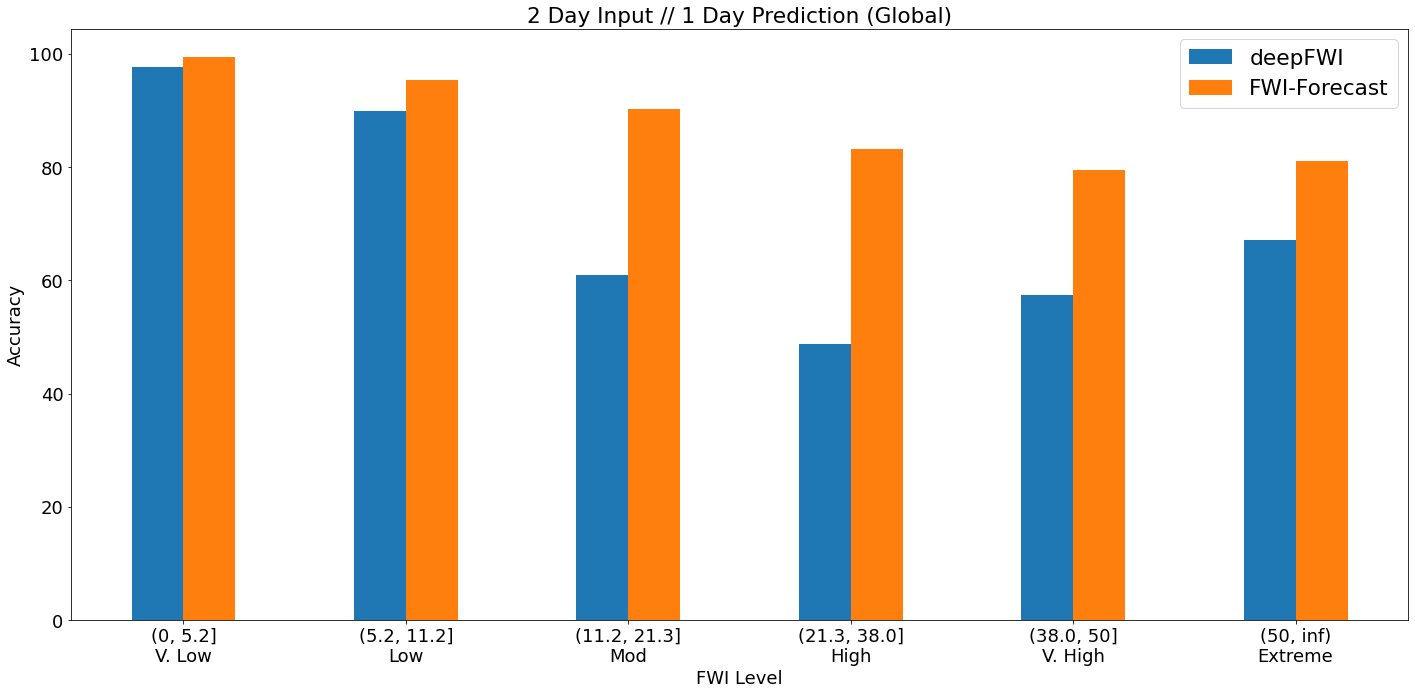

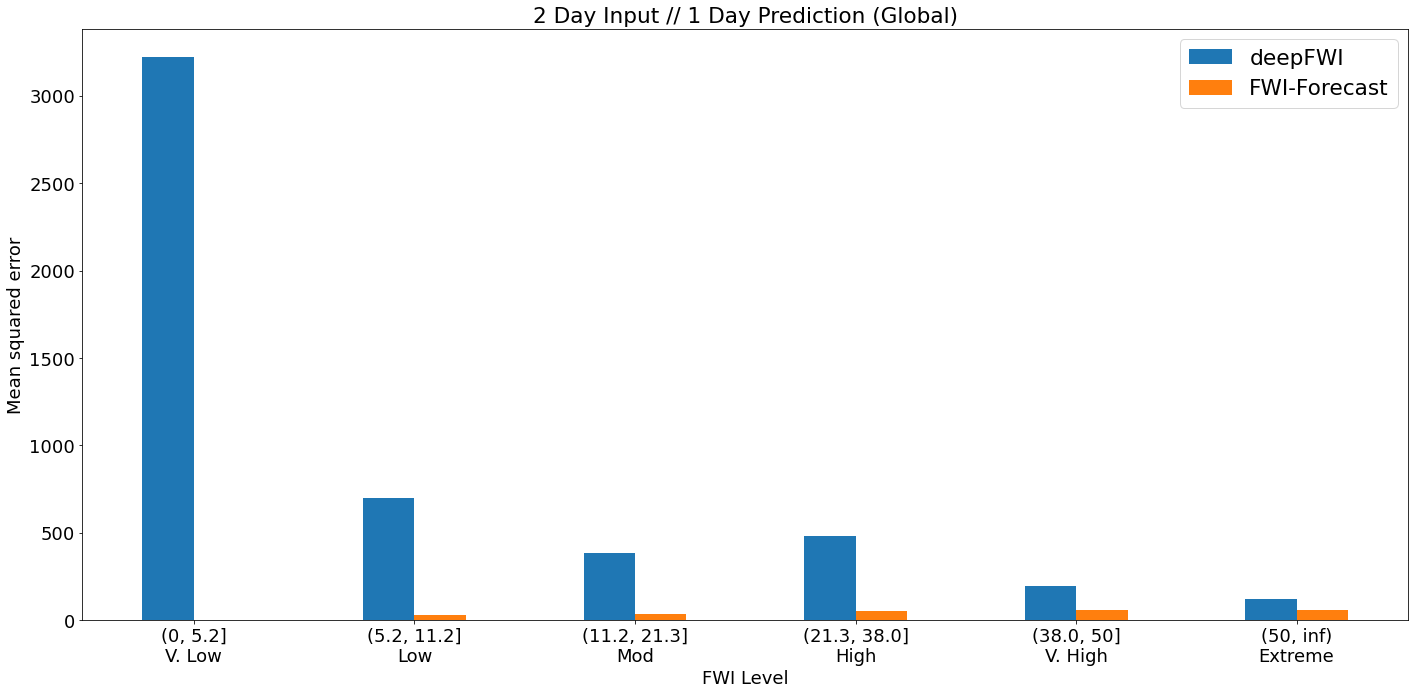

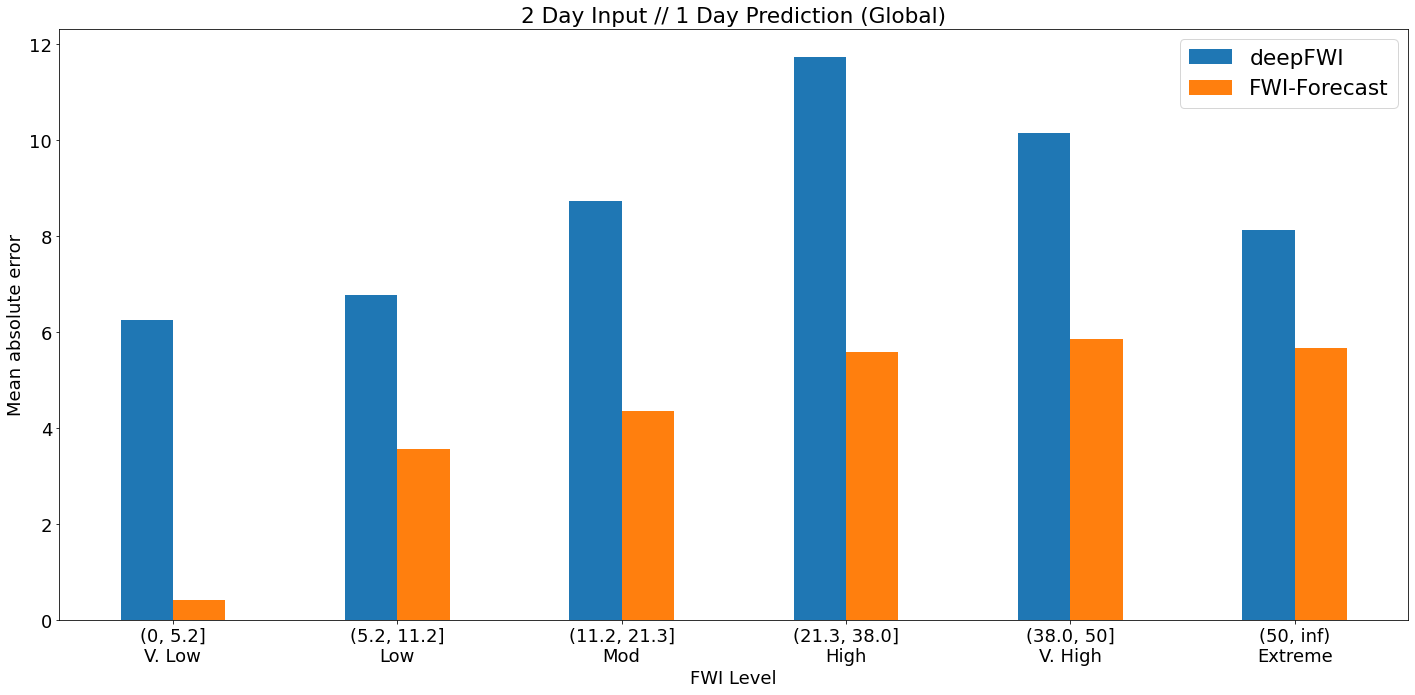

In [8]:
run(**config, benchmark=True);